In [1]:
import numpy as np
import os
import time
import cv2 as cv
import matplotlib.pyplot as plt


In [2]:
def load_FLO_file(filename):
    assert os.path.isfile(filename), 'file does not exist: ' + filename   
    flo_file = open(filename,'rb')
    magic = np.fromfile(flo_file, np.float32, count=1)
    assert magic == 202021.25,  'Magic number incorrect. .flo file is invalid'
    w = np.fromfile(flo_file, np.int32, count=1)
    h = np.fromfile(flo_file, np.int32, count=1)
    data = np.fromfile(flo_file, np.float32, count=2*w[0]*h[0])
    flow = np.resize(data, (int(h[0]), int(w[0]), 2))
    flo_file.close()
    return flow

In [3]:
class OpticalFlow():
    def __init__(self):
        # Parameters for Lucas_Kanade_flow()
        self.EIGEN_THRESHOLD = 0.01 # use as threshold for determining if the optical flow is valid when performing Lucas-Kanade
        self.WINDOW_SIZE = [25, 25] # the number of points taken in the neighborhood of each pixel

        # Parameters for Horn_Schunck_flow()
        self.EPSILON= 0.002 # the stopping criterion for the difference when performing the Horn-Schuck algorithm
        self.MAX_ITERS = 1000 # maximum number of iterations allowed until convergence of the Horn-Schuck algorithm
        self.ALPHA = 1.0 # smoothness term

        # Parameter for flow_map_to_bgr()
        self.UNKNOWN_FLOW_THRESH = 1000

        self.prev = None
        self.next = None

    def next_frame(self, img):
        self.prev = self.next
        self.next = img

        if self.prev is None:
            return False

        frames = np.float32(np.array([self.prev, self.next]))
        frames /= 255.0

        #calculate image gradient
        self.Ix = cv.Sobel(frames[0], cv.CV_32F, 1, 0, 3)
        self.Iy = cv.Sobel(frames[0], cv.CV_32F, 0, 1, 3)
        self.It = frames[1]-frames[0]

        return True

        #***********************************************************************************
    # implement Lucas-Kanade Optical Flow 
    # returns the Optical flow based on the Lucas-Kanade algorithm and visualisation result
    def Lucas_Kanade_flow(self):
        # setup kernel for window summation
        window_kernel = np.ones((self.WINDOW_SIZE)) / (self.WINDOW_SIZE[0] * self.WINDOW_SIZE[1])

        # summation of structural matrix, same as harris corner
        IxIx = self.Ix * self.Ix
        IyIy = self.Iy * self.Iy
        IxIy = self.Ix + self.Iy
        wIxIx = cv.filter2D(IxIx, ddepth=-1, kernel = window_kernel)
        wIyIy = cv.filter2D(IyIy, ddepth=-1, kernel = window_kernel)
        wIxIy = cv.filter2D(IxIy, ddepth=-1, kernel = window_kernel)
        # we have our first matrix (A^T W A)
        ATWA = np.array([
            [wIxIx, wIxIy],
            [wIxIy, wIyIy], 
        ])

        # compute the movement in axis from next frame 
        IxIt = self.Ix * self.It
        IyIt = self.Iy * self.It
        wIxIt = cv.filter2D(IxIt, ddepth=-1, kernel = window_kernel)
        wIyIt = cv.filter2D(IyIt, ddepth=-1, kernel = window_kernel)
        # we have matrix (A^T W b)
        ATWb = np.array([
            [wIxIt],
            [wIyIt],
        ])
        
        # v = (A^T W A)^-1 A^t W b
        # but we want to stop if eigenvalues are too small
        height, width = self.Ix.shape[0], self.Ix.shape[1]
        # construct array for movement u,v need two channels for both u,v
        flow = np.zeros((2, height, width))
        for i in range(height):
            for j in range(width):
                curr_ATWA = ATWA[:, :, i, j]
                curr_ATWb = - ATWb[:, :, i, j]

                # only want eigenvalues
                eigens = np.linalg.eig(curr_ATWA)[0]
                min_eigval = np.min(eigens)

                # continue according to given eig val threshold
                if min_eigval < self.EIGEN_THRESHOLD:
                    continue
                # compute the invers
                curr_ATWA_inv = np.linalg.inv(curr_ATWA)
                # with all the matrices we can compute the flow
                v = curr_ATWA_inv @ curr_ATWb
                # set flow to according pixel 
                flow[:, i, j] = v[:, 0]

        flow_rgb = self.flow_map_to_rgb(flow)
        return flow, flow_rgb

    #***********************************************************************************
    # implement Horn-Schunck Optical Flow 
    # returns the Optical flow based on the Horn-Schunck algorithm and visualisation result
    def Horn_Schunck_flow(self):
        # according to wikipedia we can solve following forumla 
        # which is derived using cramers rule

        # u_k+1 = u_k - (Ix * (Ix * u_k + Iy * uv + It) / 4 * alpha^2 + Ix^2 + Iy^2)
        # where u and v is the laplacian
        # the formula for v exchanges the factor of Ix with Iy before numerator

        # the denominator is always the same:
        denominator = self.ALPHA**2 + self.Ix**2 + self.Iy**2
        # init u and v to zero
        u = np.zeros((self.Ix.shape[0], self.Ix.shape[1]))
        v = np.zeros((self.Ix.shape[0], self.Ix.shape[1]))
        laplace_kernel = np.array([
            [0, 1/4, 0],
            [1/4, -1, 1/4],
            [0, 1/4, 0],
        ])

        for i in range(self.MAX_ITERS):
            u_laplace= cv.filter2D(u, ddepth=-1, kernel = laplace_kernel)
            v_laplace = cv.filter2D(v, ddepth=-1, kernel = laplace_kernel)
            u_prime = u + u_laplace
            v_prime = v + v_laplace
            # compute numerator part
            numerator = (self.Ix * u_prime + self.Iy * v_prime + self.It)      
            # itaretively new u and new v  
            u_new = u_prime - self.Ix * numerator / denominator    
            v_new = v_prime - self.Iy * numerator / denominator    

            # stop if criterion is met
            difference = np.abs(u_new.sum() - u.sum()) + np.abs(v_new.sum() - v.sum())
            if difference < self.EPSILON:
                u = u_new
                v = v_new
                print("Criterion for Horn Schnuck met at iteration: ", i)
                break
            # set new values
            u = u_new
            v = v_new


        flow = np.concatenate((u[None, :, :],v[None, :, :]), axis=0)
        flow_rgb = self.flow_map_to_rgb(flow)
        return flow, flow_rgb

    #***********************************************************************************
    #calculate the angular error here
    # return average angular error and per point error map
    def calculate_angular_error(self, estimated_flow, groundtruth_flow):
        
        # set u and v
        u = estimated_flow[0]
        v = estimated_flow[1]
        # set u_c and v_c
        u_c = groundtruth_flow[:, :, 0]
        v_c = groundtruth_flow[:, :, 1]
        # get img dimensions
        height, width = estimated_flow.shape[-2], estimated_flow.shape[-1]
        n = height * width
        # setup error map and loop over map
        angl_error_map = np.zeros((height, width))
        for i in range(height):
            for j in range(width):
                numerator = u_c[i,j] * u[i,j] + v_c[i,j] * v[i,j] + 1
                denominator = np.sqrt( (u_c[i,j]**2 + v[i,j]**2 + 1) * (v_c[i,j]**2 + u[i,j]**2 + 1) )
                angl_error_map[i,j] = np.arccos(numerator / denominator)
            
        average_angular_error = angl_error_map.sum() / n
        return average_angular_error, angl_error_map

#***********************************************************************************
    #calculate the endpoint error here
    # return average endpoint error and per point error map
    def calculate_endpoint_error(self, estimated_flow, groundtruth_flow):
        # set u and v
        u = estimated_flow[0]
        v = estimated_flow[1]
        # set u_c and v_c
        u_c = groundtruth_flow[:, :, 0]
        v_c = groundtruth_flow[:, :, 1]
        # get img dimensions
        height, width = estimated_flow.shape[-2], estimated_flow.shape[-1]
        n = height * width
        # setup error map and loop over map
        enp_error_map = np.zeros((height, width))
        for i in range(height):
            for j in range(width):
                enp_error_map[i,j] = ((u_c[i,j] - u[i,j])**2 + (v_c[i,j] - v[i,j])**2)
            
        average_endpoint_error = enp_error_map.sum() / n
        return average_endpoint_error, enp_error_map


#***********************************************************************************
    # function for converting flow map to to RGB image for visualisation
    # return rgb image
    def flow_map_to_rgb(self, flow):

        flow = flow[None, :, :, :]
        orig_shape = flow.shape

        max_norm = np.sqrt(np.sum(flow**2, axis=1)).max()
        epsilon = 1e-7
        normalized_flow = flow / (max_norm + epsilon)
        img = self._normalized_flow_to_image(normalized_flow)

        if len(orig_shape) == 3:
            img = img[0]  # Remove batch axis
            
        return img

    def _normalized_flow_to_image(self, normalized_flow):

        
        N, _, H, W = normalized_flow.shape
        device = normalized_flow
        flow_image = np.zeros((N, 3, H, W), dtype=np.uint8)
        colorwheel = self._make_colorwheel()  # shape [55x3]
        num_cols = colorwheel.shape[0]
        norm = np.sqrt(np.sum(normalized_flow**2, axis=1))
        a = np.arctan2(-normalized_flow[:, 1, :, :], -normalized_flow[:, 0, :, :]) / np.pi
        fk = (a + 1) / 2 * (num_cols - 1)
        k0 = np.floor(fk).astype(np.int32)
        k1 = k0 + 1
        k1[k1 == num_cols] = 0
        f = fk - k0

        for c in range(colorwheel.shape[1]):
            tmp = colorwheel[:, c]
            col0 = tmp[k0] / 255.0
            col1 = tmp[k1] / 255.0
            col = (1 - f) * col0 + f * col1
            col = 1 - norm * (1 - col)
            flow_image[:, c, :, :] = np.floor(255 * col)
        return flow_image

    def _make_colorwheel(self):
    
        RY = 15
        YG = 6
        GC = 4
        CB = 11
        BM = 13
        MR = 6

        ncols = RY + YG + GC + CB + BM + MR
        colorwheel = np.zeros((ncols, 3))
        col = 0

        # RY
        colorwheel[0:RY, 0] = 255
        colorwheel[0:RY, 1] = np.floor(255 * np.arange(0, RY) / RY)
        col = col + RY
        # YG
        colorwheel[col : col + YG, 0] = 255 - np.floor(255 * np.arange(0, YG) / YG)
        colorwheel[col : col + YG, 1] = 255
        col = col + YG
        # GC
        colorwheel[col : col + GC, 1] = 255
        colorwheel[col : col + GC, 2] = np.floor(255 * np.arange(0, GC) / GC)
        col = col + GC
        # CB
        colorwheel[col : col + CB, 1] = 255 - np.floor(255 * np.arange(CB) / CB)
        colorwheel[col : col + CB, 2] = 255
        col = col + CB
        # BM
        colorwheel[col : col + BM, 2] = 255
        colorwheel[col : col + BM, 0] = np.floor(255 * np.arange(0, BM) / BM)
        col = col + BM
        # MR
        colorwheel[col : col + MR, 2] = 255 - np.floor(255 * np.arange(MR) / MR)
        colorwheel[col : col + MR, 0] = 255
        return colorwheel

New iteration:  0

New iteration:  1

IMG data/frame_0001.png and data/frame_0002.png Lukas-Kanade: angular error: 0.8487608463009285
IMG data/frame_0001.png and data/frame_0002.png Lukas-Kanade: endpoints error: 4.504060400078856

IMG data/frame_0001.png and data/frame_0002.png Horn-Schnuck: angular error: 0.7767399561544392
IMG data/frame_0001.png and data/frame_0002.png Horn-Schnuck: endpoints error: 4.260489688519196

New iteration:  2

IMG data/frame_0002.png and data/frame_0007.png Lukas-Kanade: angular error: 1.0508116240805232
IMG data/frame_0002.png and data/frame_0007.png Lukas-Kanade: endpoints error: 11.379628366651874

IMG data/frame_0002.png and data/frame_0007.png Horn-Schnuck: angular error: 0.9971892901479138
IMG data/frame_0002.png and data/frame_0007.png Horn-Schnuck: endpoints error: 11.167164673839194



<Figure size 43600x102400 with 0 Axes>

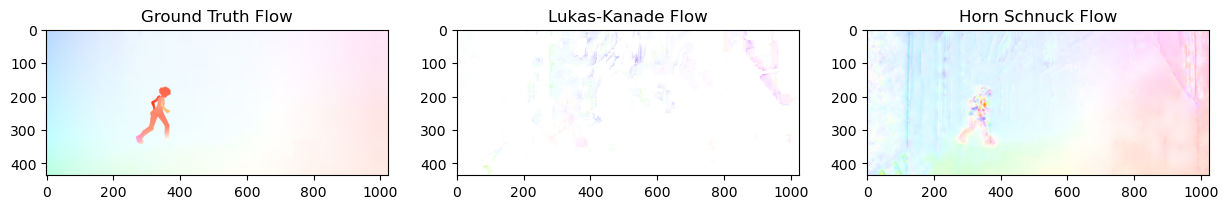

<Figure size 43600x102400 with 0 Axes>

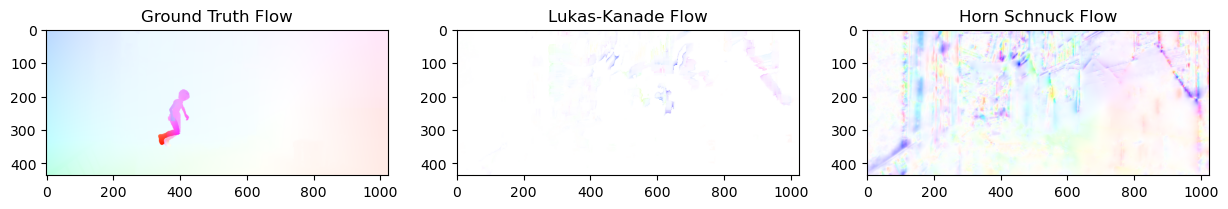

In [5]:

data_list = [
    'data/frame_0001.png',
    'data/frame_0002.png',
    'data/frame_0007.png',
]

gt_list = [
    './data/frame_0001.flo',
    './data/frame_0002.flo',
    './data/frame_0007.flo',
]

Op = OpticalFlow()

for (i, (frame_filename, gt_filemane)) in enumerate(zip(data_list, gt_list)):
    print("New iteration: ", i  )
    print("")
    groundtruth_flow = load_FLO_file(gt_filemane)
    img = cv.cvtColor(cv.imread(frame_filename), cv.COLOR_BGR2GRAY)
    if not Op.next_frame(img):
        continue

    flow_lucas_kanade, flow_lucas_kanade_rgb = Op.Lucas_Kanade_flow()    
    aae_lucas_kanade, aae_lucas_kanade_per_point = Op.calculate_angular_error (flow_lucas_kanade, groundtruth_flow)
    aee_lucas_kanade, aee_lucas_kanade_per_point = Op.calculate_endpoint_error(flow_lucas_kanade, groundtruth_flow)
    print(f"IMG {data_list[i-1]} and {data_list[i]} Lukas-Kanade: angular error: {aae_lucas_kanade}")
    print(f"IMG {data_list[i-1]} and {data_list[i]} Lukas-Kanade: endpoints error: {aee_lucas_kanade}")
    print("")


    flow_horn_schunck, flow_horn_schunck_rgb = Op.Horn_Schunck_flow()
    aae_horn_schunk, aae_horn_schunk_per_point = Op.calculate_angular_error(flow_horn_schunck, groundtruth_flow) 
    aee_horn_schunk, aee_horn_schunk_per_point = Op.calculate_endpoint_error(flow_horn_schunck, groundtruth_flow)  
    print(f"IMG {data_list[i-1]} and {data_list[i]} Horn-Schnuck: angular error: {aae_horn_schunk}")
    print(f"IMG {data_list[i-1]} and {data_list[i]} Horn-Schnuck: endpoints error: {aee_horn_schunk}")      
    print("")


    groundtruth_flow = np.transpose(groundtruth_flow, (2, 0, 1))
    flow_bgr_gt = Op.flow_map_to_rgb(groundtruth_flow)


    fig = plt.figure(figsize=(img.shape))

    _, ax = plt.subplots(1, 3, figsize=(15,7))
    if i > 0:
        ax[0].imshow(flow_bgr_gt[0].transpose(1, 2, 0))
        ax[0].set_title("Ground Truth Flow")
        ax[1].imshow(flow_lucas_kanade_rgb[0].transpose(1, 2, 0))
        ax[1].set_title("Lukas-Kanade Flow")
        ax[2].imshow(flow_horn_schunck_rgb[0].transpose(1, 2, 0))
        ax[2].set_title("Horn Schnuck Flow")

# Collect and display all the numerical results from all the runs in tabular form (the exact formating is up to your choice)


The Lukas Kanade flow seems to be wrong. Horn Schnuck for the first image seems to be reasonable. Second iteration is noisy.